# Importing required libraries and Twitter Authorization

In [13]:
import twitter
import sys
import time
from functools import partial
from sys import maxsize as max_integer
import networkx as netx
import matplotlib.pyplot as plot

class GetAuthorization:
    @staticmethod
    def twitter_login():
        try:
            #Credentials retrieved after creating the app and obtain values for authetication
            CONSUMER_KEY = 'gnpDE6vQAAT7VQMEBnTd1BVB3'
            CONSUMER_SECRET = '04aq87UuOC0YoKY0WgwjIxvkFyC7WwD4vfrqJWqE5JBNObQrGn'
            OAUTH_TOKEN = '1265568997531176961-5EmCcujIq0r5Lbn2RJOB8cSJPFmAp0'
            OAUTH_TOKEN_SECRET = 'hSefM1WNBOCJEpwQxYv99O6meO9zPUfhd8WgkeAfgEy9h'
            auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET)

            twitter_api_variable = twitter.Twitter(auth=auth)
            return twitter_api_variable
        
        except:
            print("Authorization Failed")

# Error Handling for Twitter requests

In [14]:
#Error Handling with status codes for various Twitter requests
class ErrorHandling:
    @staticmethod
    def handle_errors(e, wait_period=2, sleep_when_rate_limited=True):
        # 3600seconds/60 = 1hrs
        if wait_period > 3600: 
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e

        if e.e.code == 401:
            print('Encountered 401 Error (Not Authorized)', file=sys.stderr)
            return None

        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None

        elif e.e.code in (429, 420):
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            
            #Retrying after every 15 Minutes in case the request is not completed
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60 * 15 + 5)
                print('Trying again.', file=sys.stderr)
                return 2
            else:
                raise e  #Caller handles rate limit issue here

        elif e.e.code in (500, 502, 503, 504):
            print('Encountered {0} Error. Retrying in {1} seconds'.format(e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

# Collecting user and top followers profile

## Crawling followers to create a network

In [15]:
class TwitterData:
    
    def __init__(self, set_twitter_api_variable):
        self.twitter_api_variable = set_twitter_api_variable
        
    #Making a Twitter request
    def make_twitter_request(self, twitter_api_variable_func, max_errors=10, *args, **kw):
        wait_period = 2
        error_count = 0

        while True:
            try:
                return twitter_api_variable_func(*args, **kw)
            except twitter.api.TwitterHTTPError as e:
                error_count = 0
                wait_period = ErrorHandling.handle_errors(e, wait_period)
                if wait_period is None:
                    return

            except URLError as e:
                error_count += 1
                print >> sys.stderr, 'URLError encountered. Continuing.'
                if error_count > max_errors:
                    print >> sys.stderr, 'Too many errors...bailing out.'
                    raise

            except BadStatusLine as e:
                error_count += 1
                print >> sys.stderr, 'BadStatusLine encountered. Continuing.'
                if error_count > max_errors:
                    print >> sys.stderr, 'Too many consecutive errors...bailing out.'
                    raise
    
    # Retrieving User Profile
    def get_user_profile(self, screen_names=None, user_ids=None):
        # Must have either screen_name or user_id (logical xor)
        assert (screen_names != None) != (user_ids != None), "Must have screen_names or user_ids, but not both"
        items_to_info = {}
        items = screen_names or user_ids
        while len(items) > 0:
            items_str = ','.join([str(item) for item in items[:100]])
            items = items[100:]

            if screen_names:
                response = self.make_twitter_request(self.twitter_api_variable.users.lookup, screen_name=items_str)
            else:
                response = self.make_twitter_request(self.twitter_api_variable.users.lookup, user_id=items_str)
            for user_info in response:
                if screen_names:
                    items_to_info[user_info['screen_name']] = user_info
                else:
                    items_to_info[user_info['id']] = user_info
        return items_to_info
                    
    # Retreving ID's of followers and friends of the specified Twitter user                
    def get_friends_followers_ids(self, screen_name=None, user_id=None, friends_limit=max_integer, followers_limit=max_integer):

        # Using XOR logic to ensure that a user must have screen_name OR user_id, but not both
        assert (screen_name != None) != (user_id != None), "Must have screen_name or user_id, but not both"

        get_friends_ids = partial(self.make_twitter_request, self.twitter_api_variable.friends.ids, count=5000)
        get_followers_ids = partial(self.make_twitter_request, self.twitter_api_variable.followers.ids, count=5000)

        friends_ids, followers_ids = [], [] #creating a list to store values for friends and followers IDs
        for self.twitter_api_variable_func, limit, ids, label in [
            [get_friends_ids, friends_limit, friends_ids, "friends"],
            [get_followers_ids, followers_limit, followers_ids, "followers"]
        ]:

            if limit == 0: continue

            cursor = -1
            while cursor != 0:

                if screen_name:
                    response = self.twitter_api_variable_func(screen_name=screen_name, cursor=cursor)
                else:
                    response = self.twitter_api_variable_func(user_id=user_id, cursor=cursor)

                if response is not None:
                    ids += response['ids']
                    cursor = response['next_cursor']

                if len(ids) >= limit or response is None:
                    break

        return friends_ids[:friends_limit], followers_ids[:followers_limit]
    
    #5 most popular friends determined by their followers_count in their user profiles
    def get_top_followers(self, all_followers, top_n): #value of top_n is specified as '5' in the main function 
        top_followers = {}
        for follower in all_followers:
            followers_info = self.get_user_profile(user_ids=[follower])
            top_followers.update({followers_info[follower]["id"]: followers_info[follower]["followers_count"]})
        if (len(top_followers) >= top_n):
            min_value = sorted(top_followers.values(), reverse=True)[top_n - 1]
        elif (len(top_followers) > 1):
            min_value = sorted(top_followers.values(), reverse=True)[len(top_followers) - 1]
        else:
            min_value = 0
        top_followers = {key: value for key, value in top_followers.items() if value >= min_value} #comparing using a dictionary to check no of followers
        return top_followers
    
    #finding IDs of reciprocal friends (Distance-1 friends)
    def get_top_n_reciprocal_friends(self, id, top_n=5):
        friends_ids, followers_ids = self.get_friends_followers_ids(
            user_id=id,
            friends_limit=50,
            followers_limit=50)
        return self.get_top_followers(set(friends_ids) & set(followers_ids), top_n=top_n) #using '&' operator to find common list of reciprocal friends
   
    
    # Creating a crawler for top followers to retrieve their top followers
    def crawl_followers(self, screen_name, minimum_limit=1000, depth=2):
        userInfo = self.make_twitter_request(self.twitter_api_variable.users.show, screen_name=screen_name)
        id = userInfo['id']
        connection_dictionary = {}
        connection_graph_list = []
        unique_friends = []
        next_queue = self.get_top_n_reciprocal_friends(id) #retrieving the IDs of next reciprocal friends 
        connection_dictionary.update({id: list(next_queue)})
        connection_graph_list.append(id)
        connection_graph_list.extend(list(next_queue.keys()))
        self.graph_obj.add_a_node(id)
        self.graph_obj.add_node(list(next_queue.keys()))
        for n in list(next_queue.keys()):
            self.graph_obj.add_a_edge((id, n))
        d = 1
        next_queue_list = list(next_queue.keys())
        while len(connection_graph_list) < minimum_limit:
            print("The size of the network is : ", len(connection_graph_list))  #printing the size of the network
            d += 1
            (queue, next_queue_list) = (list(set(next_queue_list)), [])
            for fid in queue:
                top_n_reciprocal_friends = self.get_top_n_reciprocal_friends(fid)
                unique_friends = list(set(top_n_reciprocal_friends) - set(connection_graph_list))
                connection_graph_list += unique_friends
                self.graph_obj.add_node(unique_friends)
                for n in top_n_reciprocal_friends:
                    self.graph_obj.add_a_edge((fid, n))
                connection_dictionary.update({fid: unique_friends})
                next_queue_list += unique_friends
                if (len(connection_dictionary) > minimum_limit):
                    return connection_dictionary
        return connection_dictionary

    def create_a_graph_obj(self): #function to create graph
        graph_obj = graph_class()
        self.graph_obj = graph_obj

    def show_graph(self): #function to display graph
        self.graph_obj.display_graph()


# Creating and displaying Social Network Graph

In [16]:
class graph_class:

    def __init__(self):
        self.sn_graph = netx.Graph()
    def add_node(self, node_list): #Nodes from a List are added to an already existing graph
        self.sn_graph.add_nodes_from(node_list)
    def add_a_node(self, node): #Adding node to an already existing graph
        self.sn_graph.add_node(node)
    def add_edge(self, edge_list): #Edges from a List are added to an already existing graph
        self.sn_graph.add_edges_from(edge_list)
    def add_a_edge(self, edge): #Adding edge to an already existing graph
        self.sn_graph.add_edge(*edge)

    # Displaying the graph and relevent metrics
    def display_graph(self):
        print("Number of nodes in the Network : ", self.sn_graph.number_of_nodes())
        print("Number of edges in the Network : ", self.sn_graph.number_of_edges())
        print("Diameter of the Network : ", netx.diameter(self.sn_graph, e=None, usebounds=False))
        print("Average distance of the Network: ",netx.average_shortest_path_length(self.sn_graph, weight=None))
        netx.draw(self.sn_graph, with_labels=True)
        plot.savefig('The Graph.png', bbox_inches=0, orientation='landscape', pad_inches=0.5)
        plot.show()

# Main Function 


 Twitter Account for the username specified below is fetched 
Username :  VariaRuchi

 The IDs of friends are : 
[1443412697144565764, 1259134061450334208, 1659482502, 326649200, 748070827636166657, 998822393404645376, 2673567450, 1239607583666659328, 3992490315, 2611228746, 1281648390384652288, 2558402035, 1060846453822836737, 4858566948, 871558886, 1267567319238115328, 1091573076477636608, 939900873886482432, 3222137466, 1156128631413977088, 1283675661551321091, 1238867619479842817, 1166509993262112768, 943870941330751488, 549470860, 1293558439671558144, 1159838490168659968, 3324185552, 1267860818164477954, 936214867735801856, 1041697423683280896, 1141205113458978817, 1265926370128826368, 477621368, 1122158309790720000, 1937970492, 704639747788972032, 1030383833500274693, 1064472943726481408, 884068175460974594, 1009346596545314816, 1251827152523124737, 1248933791415951361, 140939773, 11348282, 380749300, 295026890, 171682730, 27260086, 34507480]

 The IDs of followers are : 
[14434

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes
Trying again.
Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes
Trying again.



 Metrics of the social network are: 
Number of nodes in the Network :  128
Number of edges in the Network :  127
Diameter of the Network :  6
Average distance of the Network:  4.947834645669292


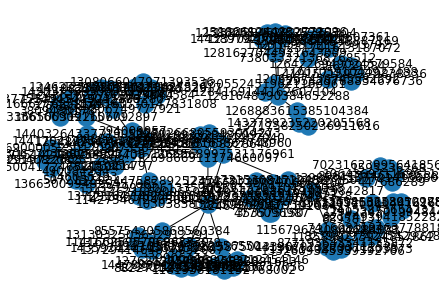

In [17]:
def main():
    try:
        print("\n Twitter Account for the username specified below is fetched ")
        screen_name = "VariaRuchi"
        print("Username : ", screen_name)

        authorization = GetAuthorization();
        twitterObj = TwitterData(authorization.twitter_login())
        friends_ids, followers_ids = twitterObj.get_friends_followers_ids(
            screen_name,
            friends_limit=50,
            followers_limit=50)

        print("\n The IDs of friends are : ")
        print(friends_ids)
        print("\n The IDs of followers are : ")
        print(followers_ids)

        print("\n The IDs of Reciprocal Friends are:")
        reciprocal_friends = set(friends_ids) & set(followers_ids)
        print(reciprocal_friends)
        print("\n The top 5 friends based on follower count are:")
        print(twitterObj.get_top_followers(reciprocal_friends, top_n=5))
        #print("\n'distance-1', 'distance-2' friends of the user in a network")
        twitterObj.create_a_graph_obj()
        twitterObj.crawl_followers(screen_name=screen_name, minimum_limit=100, depth=10)
        print("\n Metrics of the social network are: ")
        twitterObj.show_graph()
    except twitter.api.TwitterHTTPError as e:
        print("Error during Runtime")

if __name__ == "__main__":
    main()

In [ ]:
#Citation:
#1.Referred to code from slides from lectures
#2.Referred to Twitter Cookbook: Chapter 9 - Twitter Cookbook